In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble, IBMQ
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
from qiskit.tools.monitor import job_monitor
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

COUNTER = 0
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

IBMQ.save_account("07916ec631273d08971f67f1267677801b440be43215767571a165abe0ac621415a17cc5a357e2e2fffa511a6fd3748eb0c46d35ca79d8752b97788fd71f390a", overwrite=True)
IBMQ.load_account()

device = Aer.get_backend('qasm_simulator')

# Circuito

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8]), ParameterVectorElement(x[9]), ParameterVectorElement(x[10]), ParameterVectorElement(x[11]), ParameterVectorElement(x[12]), ParameterVectorElement(x[13]), ParameterVectorElement(x[14]), ParameterVectorElement(x[15])])


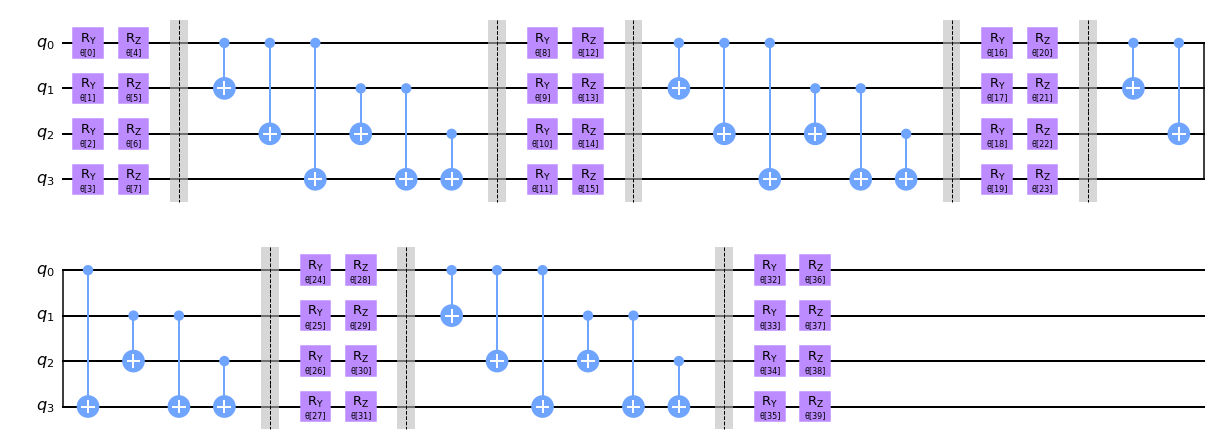

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
print(encoding.parameters)

ansatz.decompose()
qc = encoding.compose(ansatz)
qc.measure_all()
ansatz.decompose().draw(output="mpl")

In [3]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [4]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [7]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [8]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
        
    job =  execute(circuits,backend = device,shots = 1024)
    job_monitor(job)
    results = job.result()
    
    #print(results)
    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [9]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        #print(exp_val)
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat)*(y-y_hat)

In [22]:
opt_var1, opt_value1 , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True, initial_point=opt_var1)

Job Status: job has successfully run
Cost 0.95
Job Status: job has successfully run
Cost 0.8
Job Status: job has successfully run
Cost 0.85
Job Status: job has successfully run
Cost 0.65
Job Status: job has successfully run
Cost 0.4
Job Status: job has successfully run
Cost 0.85
Job Status: job has successfully run
Cost 1.2
Job Status: job has successfully run
Cost 2.0
Job Status: job has successfully run
Cost 0.9
Job Status: job has successfully run
Cost 2.0
Job Status: job has successfully run
Cost 0.7
Job Status: job has successfully run
Cost 2.0
Job Status: job has successfully run
Cost 0.85
Job Status: job has successfully run
Cost 0.4
Job Status: job has successfully run
Cost 0.45
Job Status: job has successfully run
Cost 0.6
Job Status: job has successfully run
Cost 0.65
Job Status: job has successfully run
Cost 1.0
Job Status: job has successfully run
Cost 0.4
Job Status: job has successfully run
Cost 0.4
Job Status: job has successfully run
Cost 0.8
Job Status: job has success

Job Status: job has successfully run
Cost 0.7
Job Status: job has successfully run
Cost 1.05
Job Status: job has successfully run
Cost 0.7
Job Status: job has successfully run
Cost 0.65
Job Status: job has successfully run
Cost 0.55
Job Status: job has successfully run
Cost 0.65
Job Status: job has successfully run
Cost 0.7
Job Status: job has successfully run
Cost 0.65
Job Status: job has successfully run
Cost 0.85
Job Status: job has successfully run
Cost 0.65
Job Status: job has successfully run
Cost 0.6
Job Status: job has successfully run
Cost 0.95
Job Status: job has successfully run
Cost 0.55
Job Status: job has successfully run
Cost 0.6
Job Status: job has successfully run
Cost 0.8
Job Status: job has successfully run
Cost 0.55
Job Status: job has successfully run
Cost 0.7
Job Status: job has successfully run
Cost 0.55
Job Status: job has successfully run
Cost 0.5
Job Status: job has successfully run
Cost 0.95
Job Status: job has successfully run
Cost 2.0
Job Status: job has su

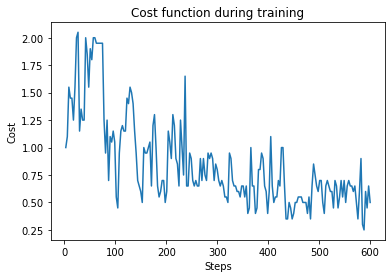

In [23]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [24]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    #backend = Aer.get_backend('qasm_simulator')
    #results =  execute(circuits, backend).result()

    
    provider = IBMQ.get_provider(hub = 'ibm-q')
    job =  execute(circuits,backend = device,shots = 1024)
    job_monitor(job)
    results = job.result()
    
    prediction = [classification(results.get_counts(c)) for c in circuits]
    #print(prediction)
    #print(labels)
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [25]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Job Status: job has successfully run
[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
[-1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1]
Test set accuracy - 0.8333333333333334


In [26]:
print(opt_value1)
print(opt_var1)

0.65
[ 1.4659109   2.43163903  3.13229679 -1.25298135  3.44564484  4.90811228
 -0.91470187  2.96045743 -0.60195502  0.06214529 -0.83655537 -0.6630929
 -0.90551965 -0.50048995 -0.36631185  0.4940339  -0.1776709  -0.91242235
  0.38923924  2.19300789 -3.8693322  -0.2998823  -3.71884233  0.70613475
  1.50357807 -0.32957481  2.09031799 -0.22977204  3.35102672 -1.74617118
  3.18521625  0.53216878 -1.05897724 -4.07063985  1.15831243  3.16769944
  2.15485575  6.05541365  3.26695215  2.61274123]


## Cross Entropy Loss

### Parity method

In [35]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [36]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [37]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [38]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True, initial_point=opt_var)

Cost: 0.48536678676225725
Cost: 0.5097021032222913
Cost: 0.4969300014651366
Cost: 0.5135350643009284
Cost: 0.5127031740602883
Cost: 0.5099339719458528
Cost: 0.5261290282266606
Cost: 0.5157624658541047
Cost: 0.5504036690628136
Cost: 0.5411174422887159
Cost: 0.5137325223695456
Cost: 0.5060407295586847
Cost: 0.51781361080491
Cost: 0.5155912991978127
Cost: 0.48551420953990726
Cost: 0.5112107683189707
Cost: 0.5225258256240475
Cost: 0.5297190515040808
Cost: 0.5185632288475638
Cost: 0.5167147735251241
Cost: 0.5122584232193519
Cost: 0.5533706674041851
Cost: 0.4878643261998802
Cost: 0.5201886833485208
Cost: 0.4957549233624604
Cost: 0.5127980754517899
Cost: 0.483266404409628
Cost: 0.5029692986079203
Cost: 0.5029271907711268
Cost: 0.517529984304048
Cost: 0.5080632191632812
Cost: 0.5213949422337381
Cost: 0.5233480147840422
Cost: 0.5568609538913223
Cost: 0.5568247410696358
Cost: 0.5330053345209542
Cost: 0.468026406177939
Cost: 0.4933450163380881
Cost: 0.519224092574625
Cost: 0.5303199110813217
Cost

Cost: 0.5913429764689961
Cost: 0.5767139917246864
Cost: 0.5916614900875815
Cost: 0.5766211630118854
Cost: 0.5727309207290541
Cost: 0.561917420494198
Cost: 0.62319236995416
Cost: 0.571850643060407
Cost: 0.588066826953295
Cost: 0.584468783661088
Cost: 0.5785143517377406
Cost: 0.617514128911983
Cost: 0.5613752302849043
Cost: 0.552900242768383
Cost: 0.5227446969669923
Cost: 0.6412506224663356
Cost: 0.6023144295790572
Cost: 0.5950072697491531
Cost: 0.6047880369397218
Cost: 0.6018423681193841
Cost: 0.6286902107147168
Cost: 0.6044220597883659
Cost: 0.6056287811341846
Cost: 0.6234978108093945
Cost: 0.6259404258539017
Cost: 0.6052127832345061
Cost: 0.5981734284906431
Cost: 0.618411183744221
Cost: 0.6037183759207223
Cost: 0.6330318448191612
Cost: 0.5730070875765261
Cost: 0.5744349425658831
Cost: 0.5499813632737786
Cost: 0.6751109067611795
Cost: 0.5685402404698057
Cost: 0.569226989250107
Cost: 0.6211430473893329
Cost: 0.5898108448403108
Cost: 0.5868307244251725
Cost: 0.5978787625510473
Cost: 0.58

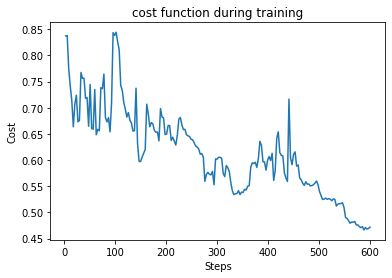

In [39]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [40]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [41]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
[-1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1]
Test set accuracy - 0.875


In [42]:
print(len(train_data))

80
